In [ ]:
# run pip install -r requirements.txt (from the root directory) to install the dependencies  

   ---------------------------------------- 0.0/772.7 kB ? eta -:--:--
   ---------------------------------------- 772.7/772.7 kB 5.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.1 MB ? eta -:--:--
   - -------------------------------------- 1.6/40.1 MB 9.3 MB/s eta 0:00:05
   --- ------------------------------------ 3.9/40.1 MB 10.7 MB/s eta 0:00:04
   ------ --------------------------------- 6.3/40.1 MB 11.3 MB/s eta 0:00:03
   --------- ------------------------------ 9.4/40.1 MB 12.0 MB/s eta 0:00:03
   ------------ --------------------------- 12.8/40.1 MB 12.6 MB/s eta 0:00:03
   ---------------- ----------------------- 16.5/40.1 MB 13.5 MB/s eta 0:00:02
   -------------------- ------------------- 20.4/40.1 MB 14.3 MB/s eta 0:00:02
   ---------------------- ----------------- 22.8/40.1 MB 14.9 MB/s eta 0:00:02
   ---------------------- ----------------- 22.8/40.1 MB 14.9 MB/s eta 0:00:02
   ---------------------- ----------------- 22.8/40.1 MB 14.9 MB/s eta 0:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import yfinance as yf

ModuleNotFoundError: No module named 'pandas._libs'

In [3]:
# Select an optionid to simulate
selected_option_id = 10010807

### 1. Load Dataset
We will load it with Polars first (suitable for large files) and convert it to a Pandas dataframe when we have filtered the selected optionid.

In [4]:
# -------------------------
# 1. Load dataset
# -------------------------

# Lazy load with polars (memory efficient for large files)
options_df = pl.scan_parquet("../data/options_dataset.parquet")

# Filter for our selected optionid
options_df = options_df.filter(pl.col("optionid") == selected_option_id).collect()

In [5]:
# Convert polars df to pandas df for easier handling
options_df = options_df.to_pandas()

In [6]:
options_df.head()

,optionid,ticker,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta
0,10010807,SPX,2000-01-03,2000-03-18,C,750000,706.500,708.500,0,1916,NaN,NaN,NaN,NaN,NaN
1,10010807,SPX,2000-01-04,2000-03-18,C,750000,651.875,653.875,0,1916,NaN,NaN,NaN,NaN,NaN
2,10010807,SPX,2000-01-05,2000-03-18,C,750000,654.375,656.375,0,1916,NaN,NaN,NaN,NaN,NaN
3,10010807,SPX,2000-01-06,2000-03-18,C,750000,644.125,646.125,0,1916,NaN,NaN,NaN,NaN,NaN
4,10010807,SPX,2000-01-07,2000-03-18,C,750000,701.500,703.500,0,1916,0.735718,0.98696,0.000072,21.18744,-84.33163


In [7]:
options_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   optionid         52 non-null     int64  
 1   ticker           52 non-null     object 
 2   date             52 non-null     object 
 3   exdate           52 non-null     object 
 4   cp_flag          52 non-null     object 
 5   strike_price     52 non-null     int64  
 6   best_bid         52 non-null     float64
 7   best_offer       52 non-null     float64
 8   volume           52 non-null     int64  
 9   open_interest    52 non-null     int64  
 10  impl_volatility  18 non-null     float64
 11  delta            18 non-null     float64
 12  gamma            18 non-null     float64
 13  vega             18 non-null     float64
 14  theta            18 non-null     float64
dtypes: float64(7), int64(4), object(4)
memory usage: 6.2+ KB


In [8]:
options_df["date"].unique()

array(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
       '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
       '2000-01-13', '2000-01-14', '2000-01-18', '2000-01-19',
       '2000-01-20', '2000-01-21', '2000-01-24', '2000-01-25',
       '2000-01-26', '2000-01-27', '2000-01-28', '2000-01-31',
       '2000-02-01', '2000-02-02', '2000-02-03', '2000-02-04',
       '2000-02-07', '2000-02-08', '2000-02-09', '2000-02-10',
       '2000-02-11', '2000-02-14', '2000-02-15', '2000-02-16',
       '2000-02-17', '2000-02-18', '2000-02-22', '2000-02-23',
       '2000-02-24', '2000-02-25', '2000-02-28', '2000-02-29',
       '2000-03-01', '2000-03-02', '2000-03-03', '2000-03-06',
       '2000-03-07', '2000-03-08', '2000-03-09', '2000-03-10',
       '2000-03-13', '2000-03-14', '2000-03-15', '2000-03-16'],
      dtype=object)

### 2. Preprocess Columns

In [9]:
# -------------------------
# 2. Preprocess data
# -------------------------

options_df['date'] = pd.to_datetime(options_df['date'], errors='coerce')

# Add mid-price column
options_df["mid_price"] = (options_df["best_bid"] + options_df["best_offer"]) / 2

### 3. Load underlying SPX prices for the option days
We will download the SPX prices from yfinance.

In [10]:
# -------------------------
# 3. Download and load underlying SPX prices
# -------------------------

ticker = "^SPX"
start_date = options_df["date"].min()
end_date = options_df["date"].max()

spx_df = yf.download(ticker, start=start_date, end=end_date)
spx_df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^SPX,^SPX,^SPX,^SPX,^SPX
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


In [11]:
spx_df = spx_df[['Close']].reset_index().rename(columns={'Date': 'date', 'Close': 'spx_close'})
spx_df.columns = [col[0] if isinstance(col, tuple) else col for col in spx_df.columns]
spx_df.head()

,date,spx_close
0,2000-01-03,1455.219971
1,2000-01-04,1399.420044
2,2000-01-05,1402.109985
3,2000-01-06,1403.449951
4,2000-01-07,1441.469971


In [12]:
options_df = options_df.merge(spx_df, on='date', how='left')

options_df.head()

,optionid,ticker,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,mid_price,spx_close
0,10010807,SPX,2000-01-03,2000-03-18,C,750000,706.500,708.500,0,1916,NaN,NaN,NaN,NaN,NaN,707.500,1455.219971
1,10010807,SPX,2000-01-04,2000-03-18,C,750000,651.875,653.875,0,1916,NaN,NaN,NaN,NaN,NaN,652.875,1399.420044
2,10010807,SPX,2000-01-05,2000-03-18,C,750000,654.375,656.375,0,1916,NaN,NaN,NaN,NaN,NaN,655.375,1402.109985
3,10010807,SPX,2000-01-06,2000-03-18,C,750000,644.125,646.125,0,1916,NaN,NaN,NaN,NaN,NaN,645.125,1403.449951
4,10010807,SPX,2000-01-07,2000-03-18,C,750000,701.500,703.500,0,1916,0.735718,0.98696,0.000072,21.18744,-84.33163,702.500,1441.469971


### 4. Delta-hedge Simulation

In [13]:
# -------------------------
# 4. Delta-hedge simulation (daily)
# -------------------------
position_option = 1  # long 1 contract
contract_size = 100  # each option contract controls 100 shares
cash = 0
underlying_pos = 0
transaction_cost_pct = 0.001  # 0.1% per trade

results = []

for idx, row in options_df.iterrows():
    date = row['date']
    spx_price = row['spx_close']
    delta = row['delta']
    mid_price = row['mid_price']

    # Target underlying position to delta-hedge
    target_underlying = - position_option * delta * contract_size
    trade = target_underlying - underlying_pos
    trade_notional = abs(trade) * spx_price
    tx_cost = trade_notional * transaction_cost_pct

    # Update cash and underlying position
    cash -= trade * spx_price + tx_cost
    underlying_pos = target_underlying

    # Mark-to-market
    option_value = mid_price * position_option * contract_size
    underlying_value = underlying_pos * spx_price
    total_value = cash + option_value + underlying_value

    results.append({
        'date': date,
        'option_value': option_value,
        'underlying_value': underlying_value,
        'cash': cash,
        'total_value': total_value,
        'tx_cost': tx_cost
    })

results_df = pd.DataFrame(results)


### 5. Plot Results

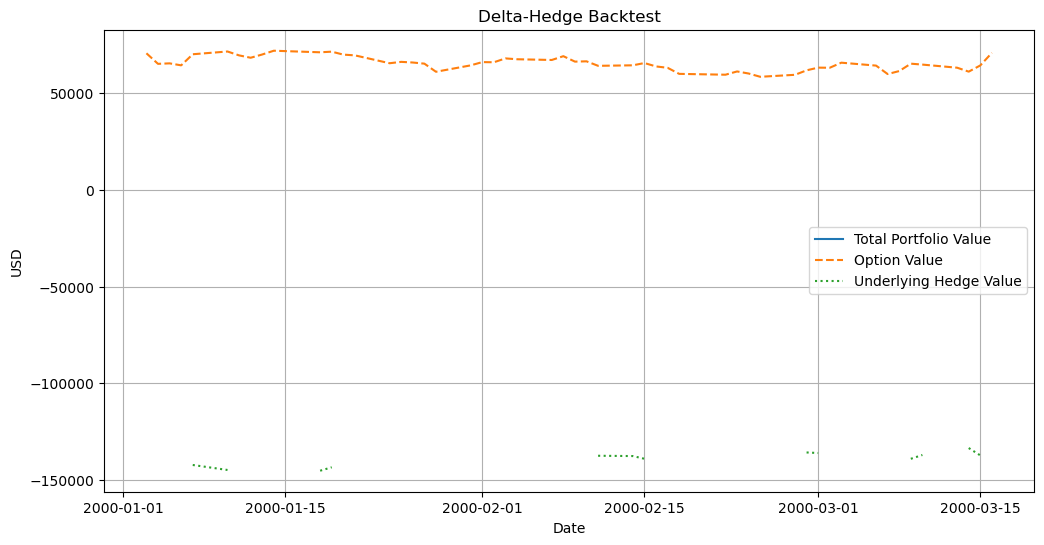

In [14]:
# -------------------------
# 5. Plot results
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(results_df['date'], results_df['total_value'], label='Total Portfolio Value')
plt.plot(results_df['date'], results_df['option_value'], label='Option Value', linestyle='--')
plt.plot(results_df['date'], results_df['underlying_value'], label='Underlying Hedge Value', linestyle=':')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Delta-Hedge Backtest')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
##Black Scholes Formula
def simulate_gbm(S0, mu, sigma, T, n_steps, n_paths, seed=None):
    """
    Simulate GBM (Black-Scholes) asset paths with exact discretization.

    Returns:
      times: array shape (n_steps+1,)
      S: array shape (n_paths, n_steps+1)
    """
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    times = np.linspace(0.0, T, n_steps + 1)
    # generate standard normals: shape (n_paths, n_steps)
    Z = rng.standard_normal(size=(n_paths, n_steps))
    # increments of log S
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * Z
    log_increments = drift + diffusion
    logS = np.concatenate([np.log(np.full((n_paths, 1), S0)), np.cumsum(log_increments, axis=1) + np.log(S0)], axis=1)
    S = np.exp(logS)
    return times, S

times, S_paths = simulate_gbm(S0=100, mu=0.0, sigma=0.2, T=1.0, n_steps=252, n_paths=1000, seed=42)
# S_paths.shape -> (1000, 253)


In [19]:
def simulate_heston_full_truncation(S0, v0, mu, kappa, theta, xi, rho,
                                    T, n_steps, n_paths, seed=None, reflect_floor=0.0):
    """
    Simulate Heston model using Euler-Maruyama with full truncation for variance.
    - S0: initial spot
    - v0: initial variance (not vol)
    - mu: drift of S (use r or 0 for risk-neutral/driftless)
    - kappa, theta: mean-reversion speed and level of variance
    - xi: volatility of variance (vol-of-vol)
    - rho: correlation between asset and variance Brownian motions (in [-1,1])
    - T, n_steps, n_paths: time horizon, steps, number of simulated paths
    - seed: RNG seed
    - reflect_floor: minimum allowed variance (small positive, e.g., 1e-8). If 0, we clip at 0.
    Returns:
      times: (n_steps+1,)
      S: (n_paths, n_steps+1)
      v: (n_paths, n_steps+1)
    """
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    sqrt_dt = np.sqrt(dt)
    times = np.linspace(0.0, T, n_steps + 1)

    S = np.zeros((n_paths, n_steps + 1))
    v = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    # Generate correlated normals: shape (n_paths, n_steps)
    # Use independent normals then mix
    Z1 = rng.standard_normal((n_paths, n_steps))
    Z2 = rng.standard_normal((n_paths, n_steps))
    W1 = Z1
    W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2  # correlated normals

    for t in range(n_steps):
        vt = np.maximum(v[:, t], 0.0)  # ensure non-neg before sqrt
        # variance (v) update - full truncation: premultiply noise by sqrt(max(v_t,0))
        dv = kappa * (theta - vt) * dt + xi * np.sqrt(np.maximum(vt, 0.0)) * sqrt_dt * W2[:, t]
        v_new = v[:, t] + dv
        # full truncation: ensure drift uses max(v_t,0) and then clamp v_new to >= 0 (or reflect_floor)
        v_new = np.maximum(v_new, reflect_floor)

        # asset price update using sqrt(max(v_t,0)) for diffusion
        diffusion_term = np.sqrt(np.maximum(vt, 0.0)) * sqrt_dt * W1[:, t]
        S_new = S[:, t] * np.exp((mu - 0.5 * vt) * dt + diffusion_term)  # log-Euler style

        v[:, t + 1] = v_new
        S[:, t + 1] = S_new

    return times, S, v
times, S_heston, v_heston = simulate_heston_full_truncation(
    S0=100, v0=0.04, mu=0.0, kappa=2.0, theta=0.04, xi=0.5, rho=-0.7,
    T=1.0, n_steps=252, n_paths=1000, seed=1234
)
# S_heston.shape -> (1000, 253)
# v_heston.shape -> (1000, 253)


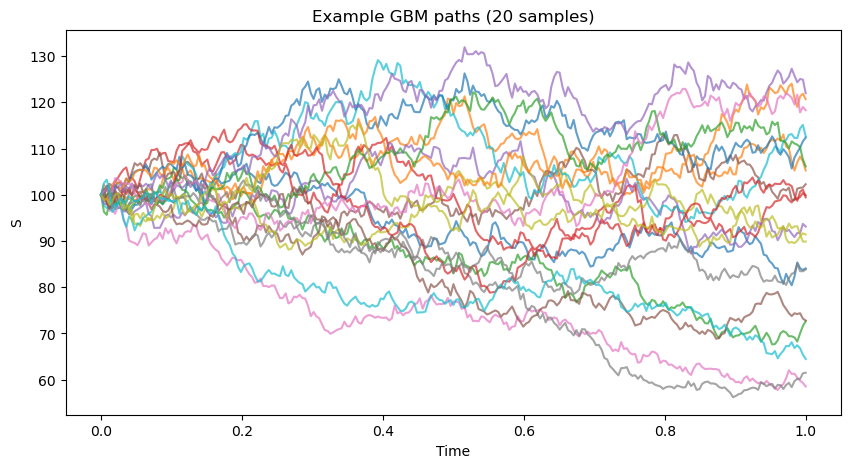

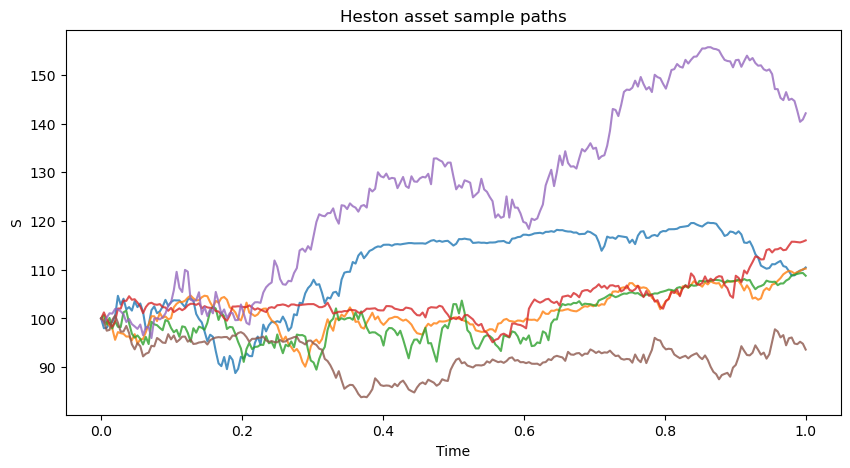

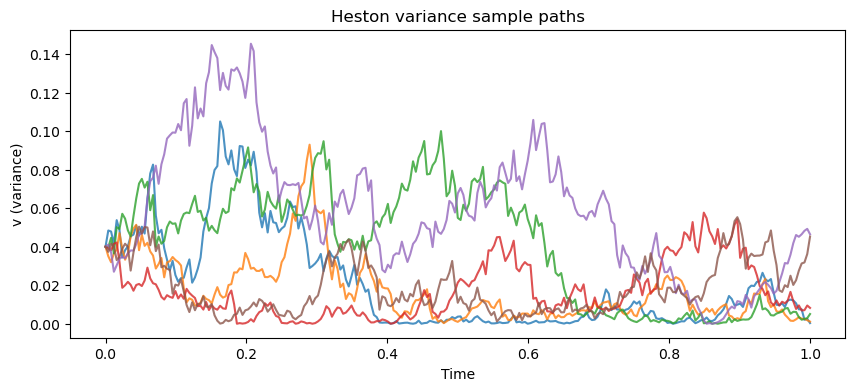

In [20]:
import matplotlib.pyplot as plt

# plot a few sample paths
plt.figure(figsize=(10, 5))
for i in range(20):
    plt.plot(times, S_paths[i, :], alpha=0.7)   # GBM
plt.title("Example GBM paths (20 samples)")
plt.xlabel("Time")
plt.ylabel("S")
plt.show()

# Heston asset + sample variance
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.plot(times, S_heston[i, :], alpha=0.8)
plt.title("Heston asset sample paths")
plt.xlabel("Time"); plt.ylabel("S"); plt.show()

plt.figure(figsize=(10, 4))
for i in range(6):
    plt.plot(times, v_heston[i, :], alpha=0.8)
plt.title("Heston variance sample paths")
plt.xlabel("Time"); plt.ylabel("v (variance)"); plt.show()


In [ ]:
from scipy.interpolate import griddata

# === 1. Load your Parquet data (already done) ===
options_df = pd.read_parquet("../data/options_dataset.parquet")

# === 2. Basic cleaning ===
options_df = options_df.dropna(subset=["impl_volatility", "strike_price"])
options_df["date"] = pd.to_datetime(options_df["date"])
options_df["exdate"] = pd.to_datetime(options_df["exdate"])

# === 3. Compute time-to-maturity (τ in years) and moneyness ===
# Need underlying price per date — here we approximate using ATM strike midpoint
spot_estimate = (
    options_df.groupby("date")["strike_price"]
    .median()
    .rename("spot")
)
options_df = options_df.merge(spot_estimate, on="date")
options_df["moneyness"] = options_df["strike_price"] / options_df["spot"]
options_df["tau"] = (options_df["exdate"] - options_df["date"]).dt.days / 365.0

# === 4. Define fixed (m, τ) grid ===
m_grid = np.linspace(0.8, 1.2, 9)     # 0.8 → 1.2
tau_grid = np.linspace(0.05, 0.5, 10) # 0.05y (~18d) → 0.5y (~6mo)
M, T = np.meshgrid(m_grid, tau_grid)
grid_points = np.column_stack([M.ravel(), T.ravel()])

# === 5. Interpolate IV surface for each trading date ===
surfaces = []
dates = []
for date, group in options_df.groupby("date"):
    pts = group[["moneyness", "tau"]].to_numpy()
    vols = group["impl_volatility"].to_numpy()

    # Skip days with too few points
    if len(vols) < 20:
        continue

    # Interpolate implied vols to fixed grid
    grid_vols = griddata(pts, vols, grid_points, method="linear", fill_value=np.nan)
    # Fill remaining NaNs with nearest
    if np.isnan(grid_vols).any():
        grid_vols = griddata(pts, vols, grid_points, method="nearest", fill_value=np.nan)

    surfaces.append(grid_vols)
    dates.append(date)

# Convert to DataFrame (each row = flattened surface)
surf_df = pd.DataFrame(surfaces, index=dates)
surf_df.index.name = "date"

# === 6. Save to CSV (VolGAN expects CSV of flattened surfaces) ===
output_dir = "../data"
surf_df.to_csv(f"{output_dir}/surfacesTransform.csv", index=True)
print(f"Saved surfacesTransform.csv with shape {surf_df.shape}")

# === 7. Optionally, create a simple SPX.csv (for datapath) ===
spx_df = pd.DataFrame({
    "Date": dates,
    "SPX": [spot_estimate.loc[d] for d in dates]
})
spx_df["log_return"] = np.log(spx_df["SPX"] / spx_df["SPX"].shift(1))
spx_df.to_csv(f"{output_dir}/SPX.csv", index=False)
print(f"Saved SPX.csv with shape {spx_df.shape}")
